# Geometrical study of transformer's dynamics

## Imports

In [3]:
# Python libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D  # Importing the 3D plotting module
import matplotlib.colors as mcolors

# Transformers libraries
import torch
import transformers
from transformers import AutoTokenizer, AutoModelForCausalLM

# Neighborhood analysis
import faiss
from sklearn.manifold import TSNE

# Surface reconstruction
from scipy.spatial import Delaunay

/home/ubuntu/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Model construction

In [4]:
model_id = "google/gemma-2b-it"
dtype = torch.bfloat16

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    torch_dtype=dtype,
)

Sentence = "O Captain! my Captain! our fearful trip is done,\nThe ship has weather’d every rack, the prize we sought is won,\nThe port is near, the bells I hear, the people all exulting,\nWhile follow eyes the steady keel, the vessel grim and daring;\nBut O heart! heart! heart!\nO the bleeding drops of red,\nWhere on the deck my Captain lies,\nFallen cold and dead.\n\nO Captain! my Captain! rise up and hear the bells;\nRise up—for you the flag is flung—for you the bugle trills,\nFor you bouquets and ribbon’d wreaths—for you the shores a-crowding,\nFor you they call, the swaying mass, their eager faces turning;\nHere Captain! dear father!\nThis arm beneath your head!\nIt is some dream that on the deck,\nYou’ve fallen cold and dead.\n\nMy Captain does not answer, his lips are pale and still,\nMy father does not feel my arm, he has no pulse nor will,\nThe ship is anchor’d safe and sound, its voyage closed and done,\nFrom fearful trip the victor ship comes in with object won;\nExult O shores, and ring O bells!\nBut I with mournful tread,\nWalk the deck my Captain lies,\nFallen cold and dead."

chat = [
    { "role": "user", "content": Sentence },
]


Gemma's activation function should be approximate GeLU and not exact GeLU.
Changing the activation function to `gelu_pytorch_tanh`.if you want to use the legacy `gelu`, edit the `model.config` to set `hidden_activation=gelu`   instead of `hidden_act`. See https://github.com/huggingface/transformers/pull/29402 for more details.


Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing
Initializing


Loading checkpoint shards: 100%|██████████| 2/2 [00:06<00:00,  3.28s/it]


### Tokenization phase

Save the vocabulary to convert tokens2words and the other way around.

In [6]:
transformer_vocabulary = AutoTokenizer.from_pretrained(model_id).get_vocab()

def get_code(code):
    return list(transformer_vocabulary.keys())[list(transformer_vocabulary.values()).index(code)]

In [7]:
prompt = tokenizer.apply_chat_template(chat, tokenize=False, add_generation_prompt=True)
input_ids = tokenizer.encode(prompt, add_special_tokens=False, return_tensors="pt")

### From token to vector

In [8]:
# Directly use the embeddings layer to get embeddings for the input_ids
with torch.no_grad():
    embeddings = model.get_input_embeddings()(input_ids)
print(embeddings.shape)
embeddings

torch.Size([1, 293, 2048])


tensor([[[ 0.1035,  0.0050, -0.0327,  ..., -0.0173, -0.0089, -0.0103],
         [ 0.5234, -0.0371,  0.0566,  ...,  0.0752,  0.2305,  0.0349],
         [ 0.2178, -0.0593, -0.0383,  ..., -0.0679,  0.0742,  0.0189],
         ...,
         [ 0.5234, -0.0371,  0.0566,  ...,  0.0752,  0.2305,  0.0349],
         [ 0.1030, -0.0381, -0.0221,  ..., -0.1514, -0.0067,  0.0559],
         [ 0.2520, -0.0422, -0.1777,  ..., -0.0220,  0.0171, -0.0381]]],
       dtype=torch.bfloat16)

Let's visualize this translation.

In [9]:
words   = []
tokens  = []
vectors = []

for i, (token, vector) in enumerate(zip(input_ids[0], embeddings[0])):
    words.append(get_code(token.item()))
    tokens.append(token.item())
    vectors.append(vector.to(torch.float32).numpy())

mapping = {
    'words':   words,
    'tokens':  tokens,
    'vectors': vectors
}
df = pd.DataFrame(mapping)

words   = np.array(words)
tokens  = np.array(tokens)
vectors = np.array(vectors)

df.head(10)

,words,tokens,vectors
0,<bos>,2,"[0.103515625, 0.0050354004, -0.032714844, 0.00..."
1,<start_of_turn>,106,"[0.5234375, -0.037109375, 0.056640625, 0.08740..."
2,user,1645,"[0.21777344, -0.059326172, -0.038330078, 0.058..."
3,\n,108,"[0.25195312, -0.042236328, -0.17773438, 0.0546..."
4,O,235302,"[0.23632812, 0.0004787445, -0.078125, 0.062255..."
5,▁Captain,18397,"[0.31054688, -0.044921875, -0.040771484, -0.02..."
6,!,235341,"[0.19921875, 0.042236328, -0.14453125, 0.06225..."
7,▁my,970,"[0.24609375, -0.015197754, -0.052734375, 0.041..."
8,▁Captain,18397,"[0.31054688, -0.044921875, -0.040771484, -0.02..."
9,!,235341,"[0.19921875, 0.042236328, -0.14453125, 0.06225..."


### T-SNE analysis

T-SNE is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embeddings and the high dimensional data. T-SNE has a cost function that is not convex, i.e. with different initializations we can get different results.

In [2]:
def apply_TSNE(df, vectors, perplexity_value = 10, n_components = 3, random_state = 42):    
    tsne   = TSNE(n_components = n_components, random_state = random_state, perplexity = perplexity_value)
    tsne2D = TSNE(n_components = n_components, random_state = random_state, perplexity = perplexity_value)
    
    embedded_vectors   = tsne.fit_transform(vectors)
    embedded_vectors2D = tsne2D.fit_transform(vectors)
    
    label_colors = {}
    colors = []
    
    string_values = df[df['words'].apply(lambda x: isinstance(x, str))]['words'].tolist()
    all_colors = list(mcolors.CSS4_COLORS)
    
    fig = plt.figure(figsize=(200, 200))
    ax = fig.add_subplot(211, projection='3d')
    indices = np.arange(0,np.shape(embedded_vectors)[0])
    ax.scatter(embedded_vectors[:, 0], embedded_vectors[:, 1], embedded_vectors[:, 2], s=20, label = df['words'], c=indices[:])
    
    counter = 0
    for txt in string_values:
        ax.text(embedded_vectors[counter, 0], embedded_vectors[counter, 1], embedded_vectors[counter, 2], txt)
        counter += 1
    
    ax.set_title(f't-SNE Visualization in 3D with Perplexity={perplexity_value}')
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_zlabel('Component 3')
    plt.show()

In [11]:
def surface_reconstruction(df, vectors, perplexity_value=10, n_components=3, random_state=42, surface_alpha = 0.5):
    # Perform t-SNE embedding
    tsne = TSNE(n_components=n_components, random_state=random_state, perplexity=perplexity_value)
    embedded_vectors = tsne.fit_transform(vectors)

    # Perform Delaunay triangulation
    tri = Delaunay(embedded_vectors)

     # Create subplots
    fig = plt.figure(figsize=(15, 10))

    # Subplot 1
    ax1 = fig.add_subplot(221, projection='3d')
    ax1.plot_trisurf(embedded_vectors[:, 0], embedded_vectors[:, 1], embedded_vectors[:, 2], triangles=tri.simplices, color='r', alpha=surface_alpha)
    ax1.set_title('View 1')
    ax1.view_init(elev=30, azim=45)

    # Subplot 2
    ax2 = fig.add_subplot(222, projection='3d')
    ax2.plot_trisurf(embedded_vectors[:, 0], embedded_vectors[:, 1], embedded_vectors[:, 2], triangles=tri.simplices, color='g', alpha=surface_alpha)
    ax2.set_title('View 2')
    ax2.view_init(elev=20, azim=135)

    # Subplot 3
    ax3 = fig.add_subplot(223, projection='3d')
    ax3.plot_trisurf(embedded_vectors[:, 0], embedded_vectors[:, 1], embedded_vectors[:, 2], triangles=tri.simplices, color='b', alpha=surface_alpha)
    ax3.set_title('View 3')
    ax3.view_init(elev=10, azim=225)

    # Subplot 4
    ax4 = fig.add_subplot(224, projection='3d')
    ax4.plot_trisurf(embedded_vectors[:, 0], embedded_vectors[:, 1], embedded_vectors[:, 2], triangles=tri.simplices, color='y', alpha=surface_alpha)
    ax4.set_title('View 4')
    ax4.view_init(elev=40, azim=315)

    plt.show()

In [1]:
apply_TSNE(df, vectors)

NameError: name 'apply_TSNE' is not defined

In [ ]:
surface_reconstruction(df, vectors, surface_alpha = 0.5)

### Positional Encoding: RoPE techniques 

In [11]:
#Brute force implementation of RoPE
def RoPE(x, pos, period = 10_000, d = 2048):
    y = np.copy(x)
    for i in range(1, d//2+1):
        theta_i = pos * period**(-2*(i-1)/d)
        rotation = np.array([[np.cos(theta_i), -np.sin(theta_i)],  
                             [np.sin(theta_i), np.cos(theta_i)]])
        y[2*i-2:2*i] = np.dot(rotation, y[2*i-2:2*i])
    return y

Rotation of the dataset with RoPE.

In [12]:
rotated_vectors = np.array([RoPE(x, i+1) for i,x in enumerate(vectors)])

df['rotated_vectors'] = rotated_vectors.tolist()
df

,words,tokens,vectors,rotated_vectors
0,<bos>,2,"[0.103515625, 0.0050354004, -0.032714844, 0.00...","[0.05169258639216423, 0.08982603251934052, -0...."
1,<start_of_turn>,106,"[0.5234375, -0.037109375, 0.056640625, 0.08740...","[-0.18408340215682983, 0.4914033114910126, -0...."
2,user,1645,"[0.21777344, -0.059326172, -0.038330078, 0.058...","[-0.20722195506095886, 0.08946465700864792, 0...."
3,\n,108,"[0.25195312, -0.042236328, -0.17773438, 0.0546...","[-0.1966521143913269, -0.16307124495506287, 0...."
4,O,235302,"[0.23632812, 0.0004787445, -0.078125, 0.062255...","[0.06749643385410309, -0.2264849692583084, 0.0..."
...,...,...,...,...
288,<end_of_turn>,107,"[0.5234375, -0.038085938, 0.05517578, 0.089843...","[0.522243320941925, -0.051954638212919235, -0...."
289,\n,108,"[0.25195312, -0.042236328, -0.17773438, 0.0546...","[0.17662864923477173, 0.18457141518592834, 0.0..."
290,<start_of_turn>,106,"[0.5234375, -0.037109375, 0.056640625, 0.08740...","[-0.1709861308336258, 0.49611255526542664, 0.0..."
291,model,2516,"[0.103027344, -0.038085938, -0.022094727, 0.02...","[-0.09520205855369568, 0.05478813871741295, -0..."


Let's reapply t-SNE to visualize what this rotation has just done.

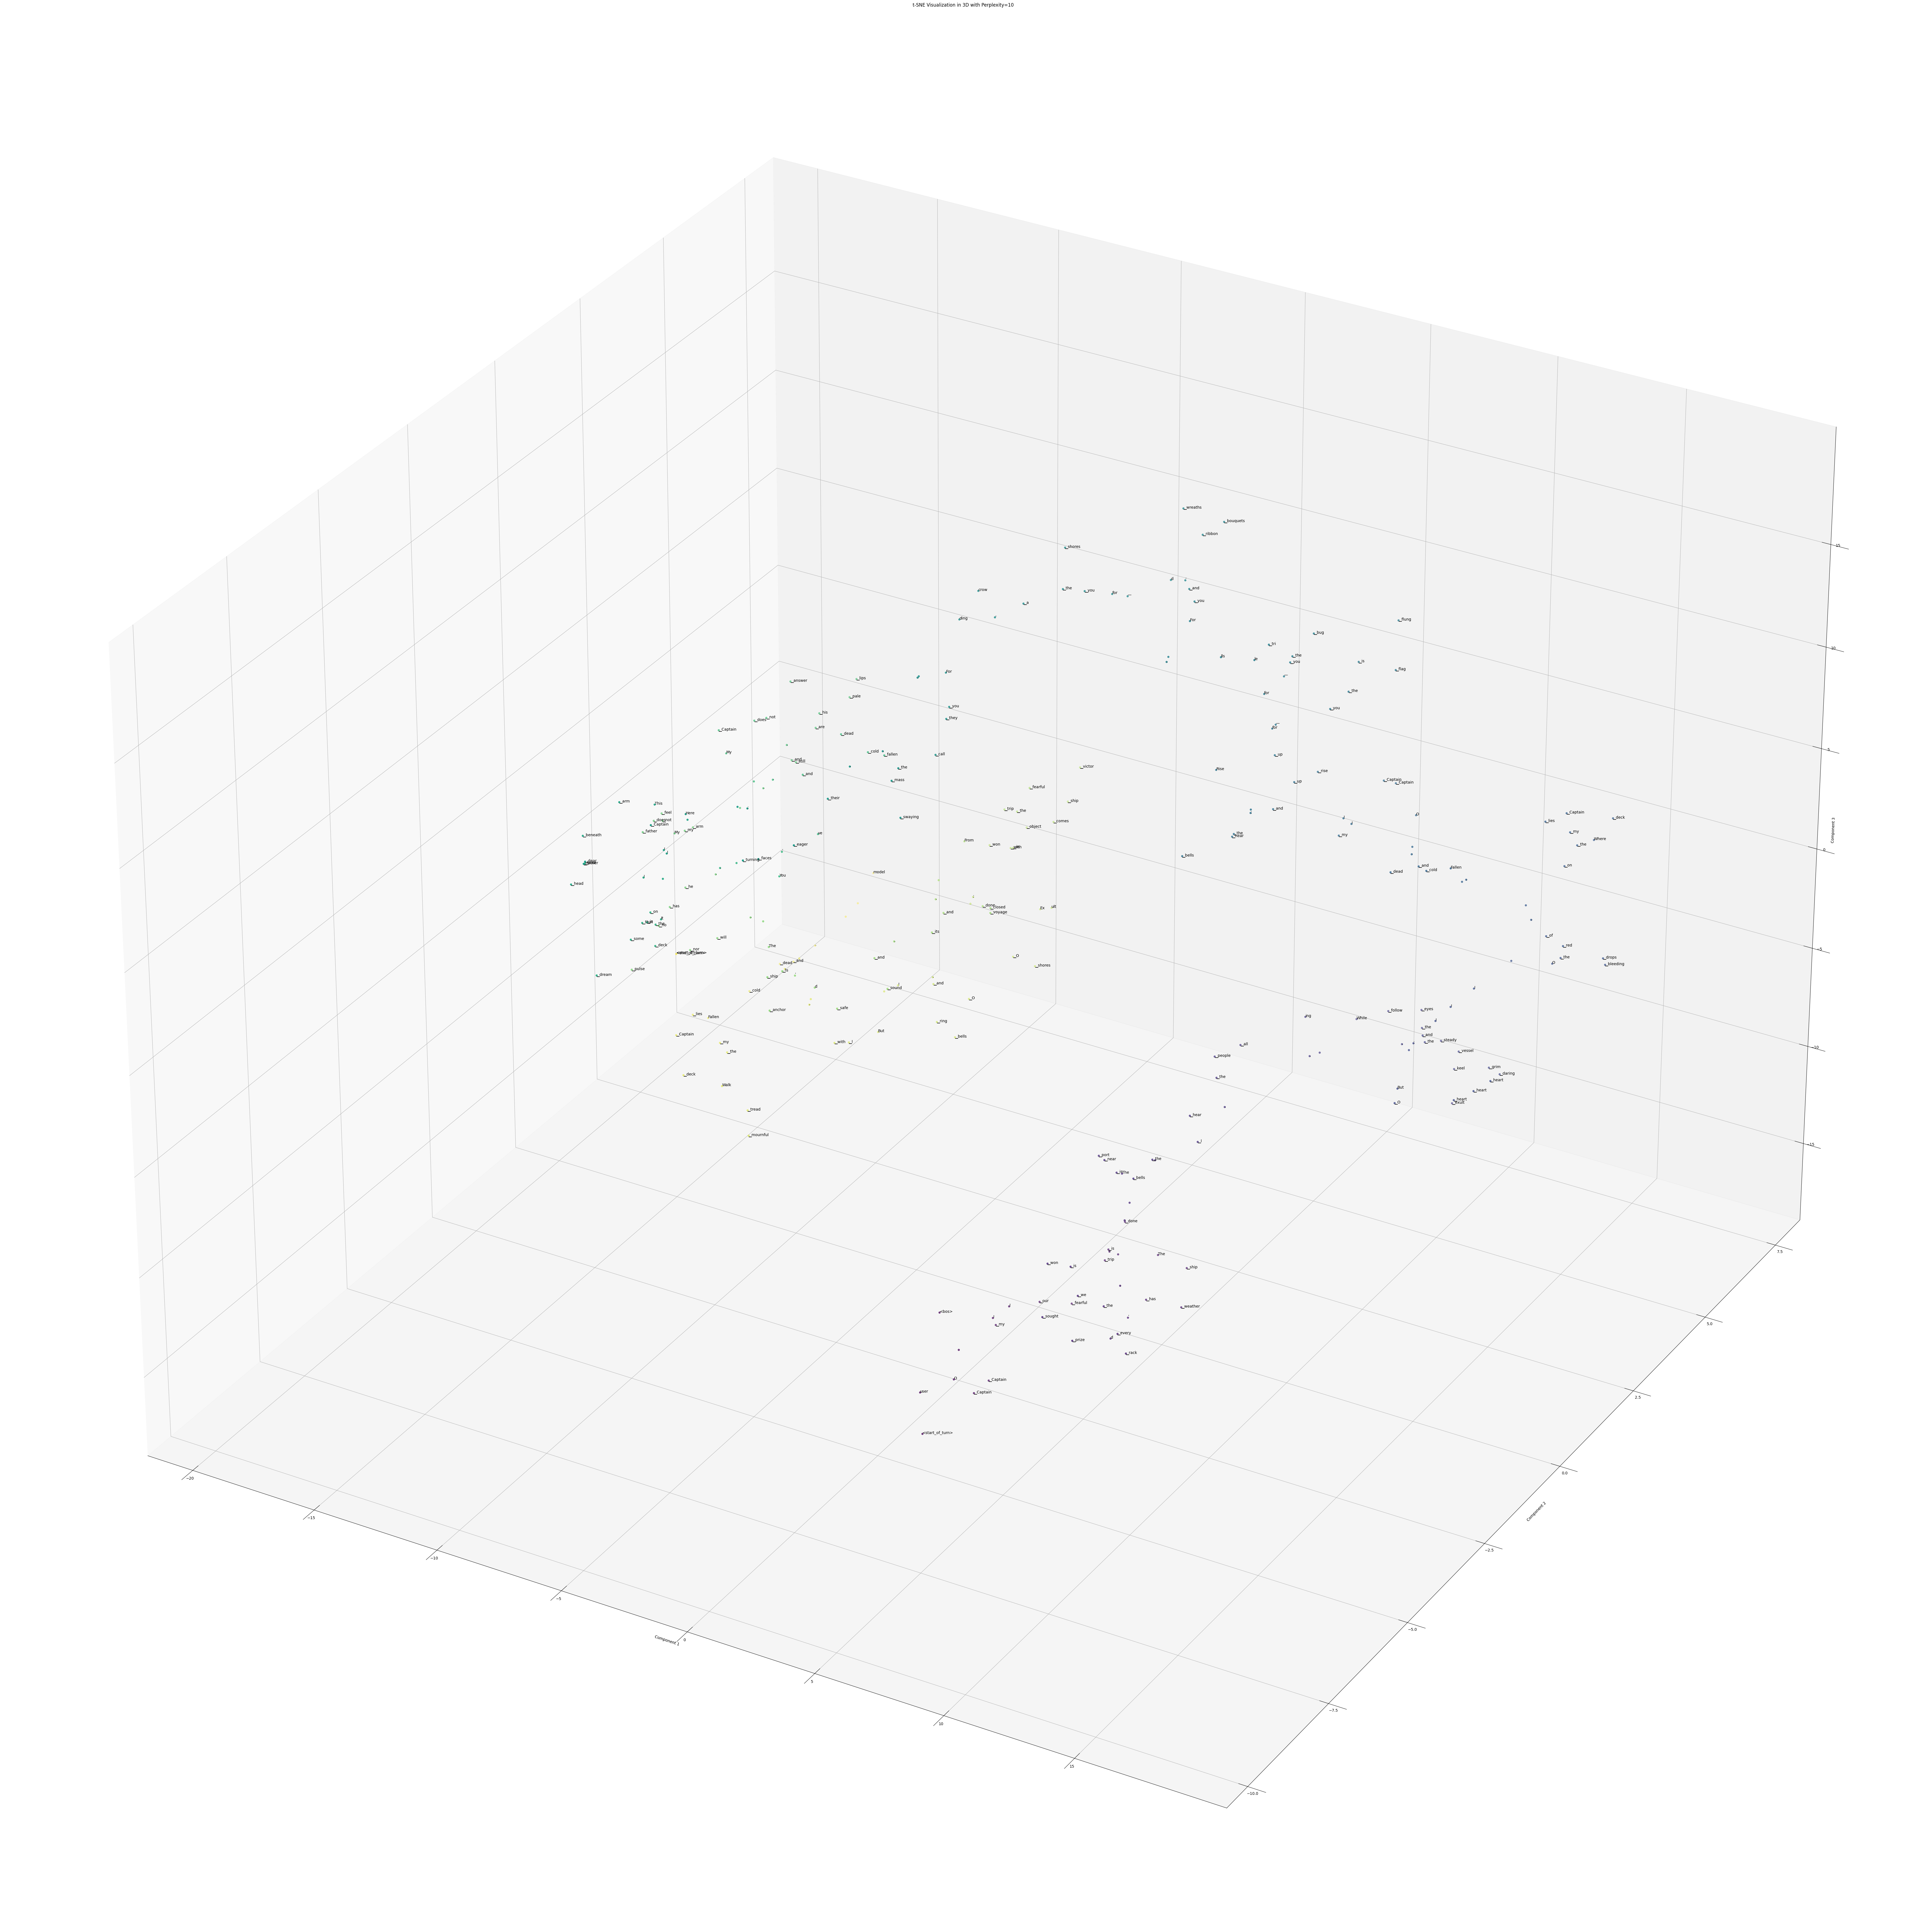

In [13]:
apply_TSNE(df, rotated_vectors)

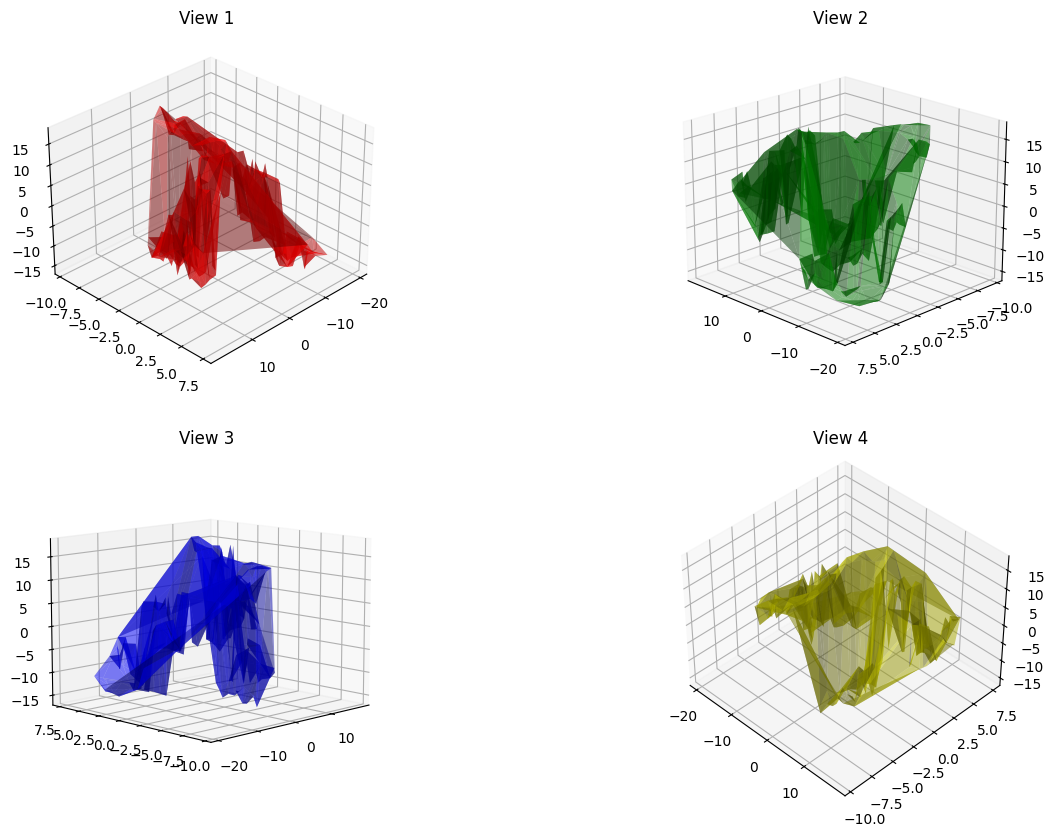

In [14]:
surface_reconstruction(df, rotated_vectors, surface_alpha = 0.5)

### Query, keys and values